Dataset: https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset/code

In [26]:
import zipfile
import os
import cv2
!pip install split-folders
import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint

In [10]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/proyek machine learning/proyek image classification model deployment/Face Mask Dataset.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [11]:
dataset_folder = '/tmp/Face Mask Dataset'

output_folder = '/tmp/facemask_resize'

target_resolution = (128, 128)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for label_folder in os.listdir(dataset_folder):
    label_path = os.path.join(dataset_folder, label_folder)

    if os.path.isdir(label_path):
        output_label_folder = os.path.join(output_folder, label_folder)

        if not os.path.exists(output_label_folder):
            os.makedirs(output_label_folder)

        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)

            image = cv2.imread(image_path)

            if image is None:
                print(f"Error: Gagal membaca gambar {image_path}")
            else:
                resized_image = cv2.resize(image, target_resolution)

                output_path = os.path.join(output_label_folder, image_file)
                cv2.imwrite(output_path, resized_image)

In [12]:
input_folder = '/tmp/facemask_resize'
splitfolders.ratio(input_folder, output='/tmp/facemask_resize',
                   seed=1337, ratio=(.8, .2), group_prefix=None)

train_dir = '/tmp/facemask_resize/train'
val_dir = '/tmp/facemask_resize/val'

Copying files: 11792 files [00:02, 4546.61 files/s]


In [13]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range = 0.2,
                    zoom_range = 0.4,
                    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
                    rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=16,
        class_mode='binary')

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(128, 128),
        batch_size=16,
        class_mode='binary')

Found 9433 images belonging to 2 classes.
Found 2359 images belonging to 2 classes.


In [15]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
model.add(Conv2D(512, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       7

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [18]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy')>=0.95) and (logs.get('val_accuracy')>=0.95):
      print('\nAccuracy is already >=95%!')
      self.model.stop_training = True
callbacks = myCallback()

history = model.fit(train_generator, epochs=10, validation_data=val_generator, batch_size=16, verbose=1, callbacks=callbacks)

Epoch 1/10
590/590 [==============================] - 73s 110ms/step - loss: 0.2822 - accuracy: 0.8917 - val_loss: 0.1988 - val_accuracy: 0.9190
Epoch 2/10
590/590 [==============================] - 67s 113ms/step - loss: 0.2092 - accuracy: 0.9239 - val_loss: 0.1252 - val_accuracy: 0.9542
Epoch 3/10
590/590 [==============================] - 64s 108ms/step - loss: 0.1929 - accuracy: 0.9292 - val_loss: 0.1492 - val_accuracy: 0.9563
Epoch 4/10
590/590 [==============================] - 65s 110ms/step - loss: 0.1716 - accuracy: 0.9370 - val_loss: 0.0994 - val_accuracy: 0.9652
Epoch 5/10
590/590 [==============================] - 64s 109ms/step - loss: 0.1694 - accuracy: 0.9418 - val_loss: 0.1050 - val_accuracy: 0.9661
Epoch 6/10
590/590 [==============================] - 68s 115ms/step - loss: 0.1563 - accuracy: 0.9469 - val_loss: 0.1175 - val_accuracy: 0.9648
Epoch 7/10
590/590 [==============================] - 64s 108ms/step - loss: 0.1559 - accuracy: 0.9439 - val_loss: 0.1090 - val_ac

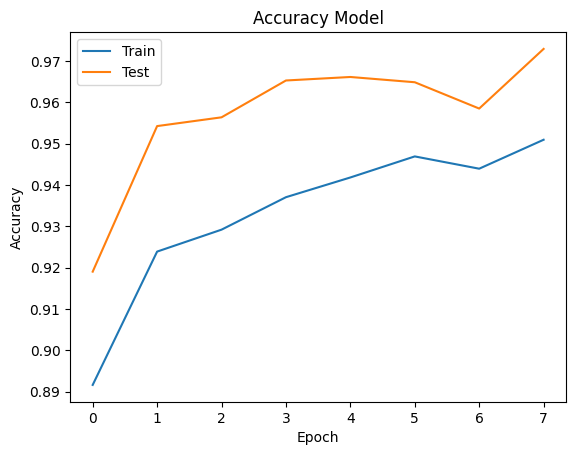

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

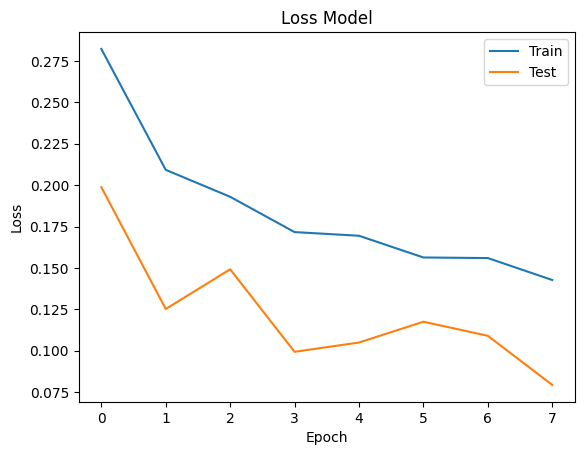

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [21]:
print(train_generator.class_indices)

{'WithMask': 0, 'WithoutMask': 1}


Saving bdf89a0b0033b943d11ed27ce5bd70d9.jpg to bdf89a0b0033b943d11ed27ce5bd70d9 (2).jpg
1/1 [==============================] - 0s 374ms/step
bdf89a0b0033b943d11ed27ce5bd70d9 (2).jpg
Without Mask


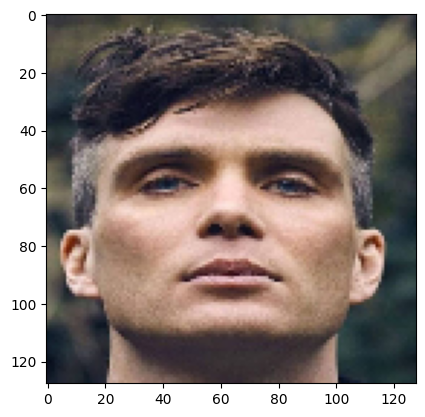

In [27]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for path in uploaded.keys():
  # predicting images
  img = image.load_img(path, target_size=(128,128))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)
  print(path)
  if classes==0:
   print('With Mask')
  else:
   print('Without Mask')

In [32]:
import pathlib

export_dir = '/content/drive/MyDrive/proyek machine learning/proyek image classification model deployment'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path(export_dir + '/vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

12177284